#  MONAI Bootcamp

# Segmentation Exercise  [baseline]
<img src="https://github.com/Project-MONAI/MONAIBootcamp2021/raw/2f28b64f814a03703667c8ea18cc84f53d6795e4/day1/monai.png" width=400>


In this exercise we will segment the left ventricle of the heart in relatively small images using neural networks. 
Below is the code for setting up a segmentation network and training it. The network isn't very good, **so the exercise is to improve the quality of the segmentation by improving the network and/or the training scheme including data loading efficiency and data augmentation**. 

The data being used here is derived from the [Sunnybrook Cardiac Dataset](https://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/) of cardiac MR images, filtered to contain only left ventricular myocardium segmentations and reduced in the XY dimensions.

<img src="https://www.cardiacatlas.org/wp-content/uploads/2015/09/scd-mri.png" width=400>


First we install and import MONAI plus other dependencies:


#### Required Packages 
This notebook has the pip command for installing MONAI and will be added to any subsequent notebook.
Execute the following cell to install MONAI the first time a colab notebook is run:

In [ ]:
#!pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.8.1"

### Check GPU Support

Running

`!nvidia-smi`

in a cell will verify this has worked and show you what kind of hardware you have access to.
if GPU Memory Usage is no `0 MiB` shutdown all kernels and restart current kernel.
- step1. shutdown kernel with following <b>Menu</b> > <b>Kernel</b> > <b>Shut Down All kernels </b>
- step2. restart kernelw with following <b>Menu</b> > <b>Kernel</b> > <b>Restart Kernel</b>


In [1]:
!nvidia-smi

Sat Nov  5 03:51:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:B7:00.0 Off |                   On |
| N/A   32C    P0    64W / 400W |   2486MiB / 81920MiB |     N/A      Default |
|                               |                      |              Enabled |
+-------------------------------+----------------------+----------------------+

+-----------------------------------------------------------------------------+
| MIG d

### Setup imports

In [2]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import torch

from urllib.request import urlopen
from io import BytesIO

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

import monai
from monai.transforms import Compose, AddChannel, ScaleIntensity, ToTensor
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.data import ArrayDataset
from torch.utils.data import DataLoader
from monai.utils import first, progress_bar
from monai.networks import one_hot
from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import set_determinism

set_determinism(0)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

## 1. Setting up our Dataset and exploring the data
#### Setup data directory

We'll create a temporary directory for all the MONAI data we're going to be using called temp directory in `~/monai-lab/temp`. 

In [3]:
import os 
import glob
directory = "temp"
if not os.path.exists(directory):
    os.makedirs(directory)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

temp


## download dataset 

We will use preprocessed Sunnybrook Cardiac MRI dataset (2MB) at  [VPH Summer SChool 2019](https://www.vph-institute.org/events/2019-vph-summer-school.html)

You can check for further research
- Sunnybrook Cardiac MRI dataset(30MB) in [kaggle](https://www.kaggle.com/datasets/salikhussaini49/sunnybrook-cardiac-mri)
- Sunnybrook Cardiac Data DICOM file(2.6GB) at [Cardiac Atlas Project](https://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/)

In [4]:
device = torch.device("cuda:0")
DATA_NPZ = "https://github.com/ericspod/VPHSummerSchool2019/raw/master/scd_lvsegs.npz"

We now load the data from the remote source and visualize a sample:

In [5]:
%%time
remote_file = urlopen(DATA_NPZ)
npz = BytesIO(remote_file.read())

CPU times: user 30.3 ms, sys: 11.7 ms, total: 42 ms
Wall time: 882 ms


(420, 64, 64) (420, 64, 64)


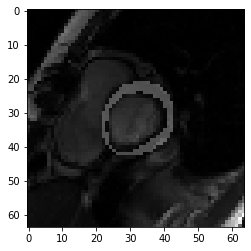

In [6]:
data = np.load(npz)  # load all the data from the archive

images = data["images"]  # images in BHW array order
segs = data["segs"]  # segmentations in BHW array order
case_indices = data["caseIndices"]  # the indices in `images` for each case

images = images.astype(np.float32) / images.max()  # normalize images

print(images.shape, segs.shape)
plt.imshow(images[13] + segs[13] * 0.25, cmap="gray")  # show image 13 with segmentation

We will split our data into a training and validation set by keeping the last 6 cases as the latter:

In [7]:
valid_index = case_indices[-6, 0]  # keep the last 6 cases for testing

# divide the images, segmentations, and categories into train/test sets
train_images, train_segs = images[:valid_index], segs[:valid_index]
valid_images, valid_segs = images[valid_index:], segs[valid_index:]

We can now create a MONAI data loading object to compose batches during training, and another for validation:

In [8]:
batch_size = 50
num_workers = 2

image_trans = Compose(
    [
        ScaleIntensity(),  # rescale image data to range [0,1]
        AddChannel(),  # add 1-size channel dimension
        ToTensor(),  # convert to tensor
    ]
)

seg_trans = Compose([AddChannel(), ToTensor()])

ds = ArrayDataset(train_images, image_trans, train_segs, seg_trans)
loader = DataLoader(
    dataset=ds,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

val_ds = ArrayDataset(valid_images, image_trans, valid_segs, seg_trans)
val_loader = DataLoader(
    dataset=val_ds,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

im, seg = first(loader)
print(im.shape, im.min(), im.max(), seg.shape)

torch.Size([50, 1, 64, 64]) tensor(0.) tensor(1.) torch.Size([50, 1, 64, 64])


We now define out simple network. This doesn't do a good job so consider how to improve it by adding layers or other elements:

### Monai Network
MONAI provides predefined networks. we can easily import it. 

- [Layers](https://docs.monai.io/en/stable/networks.html#layers) : Act, Conv, Norm, Dropout, Flatten, Reshape, Pad, Pool, SkipConnection
- [Blocks](https://docs.monai.io/en/stable/networks.html#module-monai.networks.blocks) : ADN, Convolution, Synamic UnetBlock, FCN, GCN, Squeeze-andExcitation, ResNeXt, SABlock, Transformer Block, 
- [Nets](https://docs.monai.io/en/stable/networks.html#nets)  : DenseNet121, EfficientNet, SegResNet, ResNet, SENet154, DyUNet, UNet, AutoEncoder, VarAutoEncoder, ViT, 

We now define out simple network. This doesn't do a good job so consider how to improve it by adding layers or other elements:

# BaseLine Model 

SegNet : 
 - Input 
 - Conv2D
 - MaxPool2D
 - Conv3D
 - ConvT2D
 - Conv2d
 - Output 

<p><img align='left' src="https://miro.medium.com/max/1400/1*nGFy96r63GwSE_EsJDLMDw.png" width=600>  </p>
<br>


In [9]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # layer 1: convolution, normalization, downsampling
            nn.Conv2d(1, 2, 3, 1, 1),
            nn.BatchNorm2d(2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2, 1),
            # layer 2
            nn.Conv2d(2, 4, 3, 1, 1),
            # layer 3
            nn.ConvTranspose2d(4, 2, 3, 2, 1, 1),
            nn.BatchNorm2d(2),
            nn.ReLU(),
            # layer 4: output
            nn.Conv2d(2, 1, 3, 1, 1),
        )

    def forward(self, x):
        return self.model(x)

In [10]:
net = SegNet()
net = net.to(device)

### loss and metric

In [11]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
loss = DiceLoss(sigmoid=True)
metric = DiceMetric(include_background=True, reduction="mean")

### configure optimizer

In [12]:
lr = 3e-3
opt = torch.optim.Adam(net.parameters(), lr)

In [13]:
num_epochs = 200

### train loop

In [14]:
step_losses = []
epoch_metrics = []
total_step = 0

In [15]:
%%time 
print("start train")

for epoch in range(num_epochs):
    net.train()

    # train network with training images
    for bimages, bsegs in loader:
        bimages = bimages.to(device)
        bsegs = bsegs.to(device)

        opt.zero_grad()

        prediction = net(bimages)
        loss_val = loss(torch.sigmoid(prediction), bsegs)
        loss_val.backward()
        opt.step()

        step_losses.append((total_step, loss_val.item()))
        total_step += 1

    net.eval()
    metric_vals = []

    # test our network using the validation dataset
    with torch.no_grad():
        for bimages, bsegs in val_loader:
            bimages = bimages.to(device)
            bsegs = bsegs.to(device)

            prediction = net(bimages)

            mvals = metric(y_pred=torch.sigmoid(prediction) > 0.5, y=bsegs)
            metric_vals += mvals.cpu().data.numpy().flatten().tolist()

    epoch_metrics.append((total_step, np.average(metric_vals)))

    progress_bar(epoch + 1, num_epochs, f"Validation Metric: {epoch_metrics[-1][1]:7.3}")

start train
200/200 Validation Metric:    0.31 [==============================]
CPU times: user 23.7 s, sys: 38.1 s, total: 1min 1s
Wall time: 2min 37s


We now graph the results from our training and find the results are not very good:

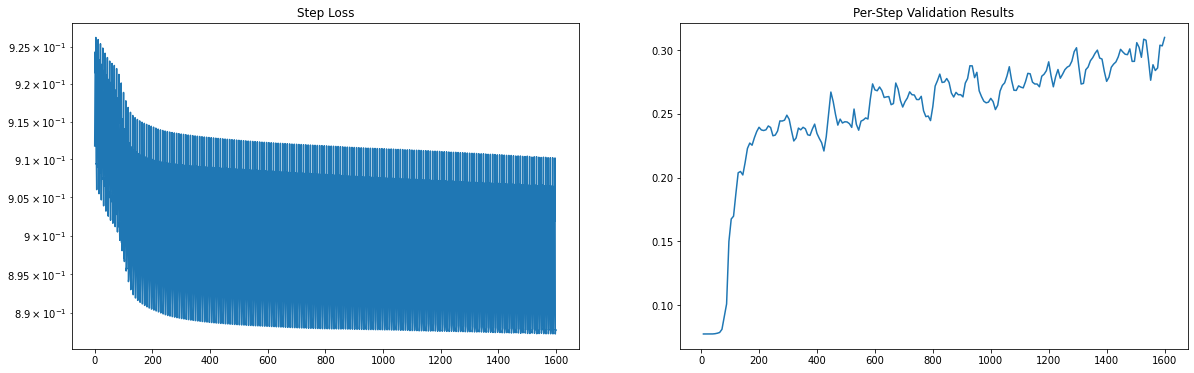

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].semilogy(*zip(*step_losses))
ax[0].set_title("Step Loss")

ax[1].plot(*zip(*epoch_metrics))
ax[1].set_title("Per-Step Validation Results")
plt.show()

## 👉 Challenge: Improve Results and Implementation 👈

### 1. Improve Data Pipeline

The pipeline currently has a very basic set of transforms. We'd want to add new transforms which will add regularization to our training process, specifically modifying the image and segmentations to make the learning problem a little harder. 

The dataset being used is `ArrayDataset` but we have in MONAI `NPZDictItemDataset` for loading data from Numpy's NPZ file format. Change the code to use this class instead. You'll need a different way of getting `caseIndices` and splitting the dataset using it.


### 2. Improve/Replace Network

As you can see we're not getting good results from our network. The training loss values are jumping around and not decreasing much anymore. The validation score has topped out at 0.25, which is really poor. 

It's now up to you to improve the results of our segmentation task. The things to consider changing include the network itself, how data is loaded, how batches might be composed, and what transforms we want to use from MONAI. 

### 3. Replace The Training Loop

This notebook uses a simple training loop with validation done explicitly. Replace this with a use of the `SupervisedTrainer` class and `SupervisedEvaluator` to do the evaluation throughout the training process. The graph plotting is done simply by recording values at each iteration through the loop, you'll want to use some other mechanism to do the same thing such as using a `MetricLogger` handler object.

## Caution !!!
### please shutdown all kernels with [Kernel] menu >  [Shutdown All Kernel]  before launch next notebook

## Navigation
- [01_getting started](./01_getting.ipynb)

- [02_pipeline_01](./02_pipeline_01.ipynb)
- [02_pipeline_02 ](./02_pipeline_02.ipynb)
- [02_pipeline_03](./02_pipeline_03.ipynb)
- [02_pipeline_04  ](./02_pipeline_04.ipynb)

- [03_brain_gan ](./03_brain_gan_01.ipynb)

- [04_spleen_segment ](./04_spleen_segment.ipynb) 

- [05_challenge_cardiac baseline  ](./05_challenge_cardiac_baseline.ipynb) 

- [05_challenge_cardiac workspace next ](./05_challenge_cardiac_workspace.ipynb) 

<img src="https://github.com/Project-MONAI/MONAIBootcamp2021/raw/2f28b64f814a03703667c8ea18cc84f53d6795e4/day1/monai.png" width=400>